On va tester 10 modèles de classification sur notre jeu de données 

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
import pickle

# Modèles de classification
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import (RandomForestClassifier, 
                               GradientBoostingClassifier, 
                               AdaBoostClassifier)
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                              f1_score, roc_auc_score, confusion_matrix, 
                              classification_report, roc_curve)

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score,
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score,
    roc_curve
)

## 2. Chargement et préparation des données

Nous allons réutiliser le code du notebook de cleaning pour obtenir les données préparées.

In [26]:
# Chargement des données brutes
df = pd.read_csv('prosperLoanData.csv')

print(f"Shape initiale: {df.shape}")
print(f"\nColonnes: {df.columns.tolist()[:10]}...")  # Afficher les 10 premières colonnes

Shape initiale: (113937, 81)

Colonnes: ['ListingKey', 'ListingNumber', 'ListingCreationDate', 'CreditGrade', 'Term', 'LoanStatus', 'ClosedDate', 'BorrowerAPR', 'BorrowerRate', 'LenderYield']...


### 2.1 Création de la variable cible binaire

In [27]:
# Vérifier les valeurs uniques de LoanStatus
print("Valeurs uniques de LoanStatus:")
print(df["LoanStatus"].value_counts())

# Filtrer les données pour ne garder que les statuts pertinents
df = df[df["LoanStatus"].isin(['Completed', 'Current', 'Defaulted',
       'Chargedoff', 'FinalPaymentInProgress', 'Past Due (>120 days)',
       'Past Due (1-15 days)', 'Past Due (16-30 days)',
       'Past Due (31-60 days)', 'Past Due (61-90 days)',
       'Past Due (91-120 days)'])]

# Créer la variable cible binaire
# 0 = Bon prêt (Completed, Current, FinalPaymentInProgress)
# 1 = Mauvais prêt (Defaulted, Chargedoff, Past Due)
df["LoanStatusBinaire"] = df["LoanStatus"].apply(
    lambda x: 0 if x in ['Completed', 'Current', 'FinalPaymentInProgress'] else 1
)

print("\nDistribution de la variable cible:")
print(df["LoanStatusBinaire"].value_counts())
print("\nPourcentage:")
print((df["LoanStatusBinaire"].value_counts(normalize=True) * 100).round(2))

Valeurs uniques de LoanStatus:
LoanStatus
Current                   56576
Completed                 38074
Chargedoff                11992
Defaulted                  5018
Past Due (1-15 days)        806
Past Due (31-60 days)       363
Past Due (61-90 days)       313
Past Due (91-120 days)      304
Past Due (16-30 days)       265
FinalPaymentInProgress      205
Past Due (>120 days)         16
Cancelled                     5
Name: count, dtype: int64

Distribution de la variable cible:
LoanStatusBinaire
0    94855
1    19077
Name: count, dtype: int64

Pourcentage:
LoanStatusBinaire
0    83.26
1    16.74
Name: proportion, dtype: float64


### 2.2 Sélection des variables pertinentes

Pour le GLM, nous devons sélectionner des variables qui ont du sens pour la prédiction et qui ne causent pas de problèmes de multicolinéarité.

In [28]:
# Liste des colonnes à exclure (variables cibles, identifiants, dates complexes)
cols_to_exclude = [
    'LoanStatus',  # Variable source de la cible
    'LoanStatusBinaire',  # Variable cible (à séparer)
    'ListingKey',  # Identifiant
    'LoanKey',  # Identifiant
    'ListingCreationDate',  # Date
    'DateCreditPulled',  # Date
    'FirstRecordedCreditLine',  # Date
    'ClosedDate',  # Date
    'LoanOriginationDate',  # Date
    'LoanNumber',  # Identifiant
    'MemberKey',  # Identifiant
    'LoanOriginationQuarter',  # Date
]

# Colonnes disponibles après exclusion
available_cols = [col for col in df.columns if col not in cols_to_exclude]

print(f"Nombre de colonnes disponibles: {len(available_cols)}")
print(f"\nExemples de colonnes: {available_cols[:20]}")



Nombre de colonnes disponibles: 70

Exemples de colonnes: ['ListingNumber', 'CreditGrade', 'Term', 'BorrowerAPR', 'BorrowerRate', 'LenderYield', 'EstimatedEffectiveYield', 'EstimatedLoss', 'EstimatedReturn', 'ProsperRating (numeric)', 'ProsperRating (Alpha)', 'ProsperScore', 'ListingCategory (numeric)', 'BorrowerState', 'Occupation', 'EmploymentStatus', 'EmploymentStatusDuration', 'IsBorrowerHomeowner', 'CurrentlyInGroup', 'GroupKey']


### 2.3 Gestion des valeurs manquantes et sélection finale des features

In [29]:
# Créer un sous-ensemble avec les colonnes disponibles + la cible
df_model = df[available_cols + ['LoanStatusBinaire']].copy()

# Afficher les valeurs manquantes
missing_pct = (df_model.isnull().sum() / len(df_model) * 100).sort_values(ascending=False)
missing_pct = missing_pct[missing_pct > 0]

print("Pourcentage de valeurs manquantes par colonne:")
print(missing_pct.head(20))

# Supprimer les colonnes avec plus de 50% de valeurs manquantes
cols_to_keep = missing_pct[missing_pct <= 50].index.tolist()
cols_to_keep = [col for col in available_cols if col not in missing_pct.index or col in cols_to_keep]

print(f"\nNombre de colonnes conservées: {len(cols_to_keep)}")

Pourcentage de valeurs manquantes par colonne:
GroupKey                               88.291261
LoanFirstDefaultedCycleNumber          85.120949
ScorexChangeAtTimeOfListing            83.386581
ProsperPaymentsLessThanOneMonthLate    80.615630
ProsperPaymentsOneMonthPlusLate        80.615630
TotalProsperPaymentsBilled             80.615630
OnTimeProsperPayments                  80.615630
TotalProsperLoans                      80.615630
ProsperPrincipalBorrowed               80.615630
ProsperPrincipalOutstanding            80.615630
CreditGrade                            74.591862
EstimatedReturn                        25.523119
ProsperRating (numeric)                25.523119
ProsperRating (Alpha)                  25.523119
EstimatedLoss                          25.523119
EstimatedEffectiveYield                25.523119
ProsperScore                           25.523119
DebtToIncomeRatio                       7.507987
EmploymentStatusDuration                6.689078
AmountDelinquent      

In [30]:
# Créer le dataframe final pour la modélisation
df_model = df[cols_to_keep + ['LoanStatusBinaire']].copy()

# Supprimer les lignes avec des valeurs manquantes dans la cible
df_model = df_model.dropna(subset=['LoanStatusBinaire'])

print(f"Shape du dataframe pour la modélisation: {df_model.shape}")

# Identifier les colonnes numériques et catégorielles
numeric_cols = df_model.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'LoanStatusBinaire']

categorical_cols = df_model.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nNombre de variables numériques: {len(numeric_cols)}")
print(f"Nombre de variables catégorielles: {len(categorical_cols)}")
print(f"\nExemples de variables numériques: {numeric_cols[:10]}")
print(f"\nExemples de variables catégorielles: {categorical_cols[:10]}")

Shape du dataframe pour la modélisation: (113932, 60)

Nombre de variables numériques: 51
Nombre de variables catégorielles: 5

Exemples de variables numériques: ['ListingNumber', 'Term', 'BorrowerAPR', 'BorrowerRate', 'LenderYield', 'EstimatedEffectiveYield', 'EstimatedLoss', 'EstimatedReturn', 'ProsperRating (numeric)', 'ProsperScore']

Exemples de variables catégorielles: ['ProsperRating (Alpha)', 'BorrowerState', 'Occupation', 'EmploymentStatus', 'IncomeRange']


### 2.4 Imputation des valeurs manquantes

In [31]:
# Imputation simple des valeurs manquantes
# Pour les numériques: médiane
for col in numeric_cols:
    if df_model[col].isnull().sum() > 0:
        df_model[col].fillna(df_model[col].median(), inplace=True)

# Pour les catégorielles: mode
for col in categorical_cols:
    if df_model[col].isnull().sum() > 0:
        df_model[col].fillna(df_model[col].mode()[0], inplace=True)

print(f"Valeurs manquantes restantes: {df_model.isnull().sum().sum()}")

Valeurs manquantes restantes: 0


## 3. Préparation des données pour le GLM

### 3.1 Séparation X et y

In [32]:
# Séparation des features et de la cible
X = df_model.drop('LoanStatusBinaire', axis=1)
y = df_model['LoanStatusBinaire']

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(f"\nDistribution de y:")
print(y.value_counts())

Shape de X: (113932, 59)
Shape de y: (113932,)

Distribution de y:
LoanStatusBinaire
0    94855
1    19077
Name: count, dtype: int64


### 3.2 Train/Test Split (70-30)

In [33]:
# Split stratifié pour conserver la proportion de la cible
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

print(f"Taille du train set: {X_train.shape}")
print(f"Taille du test set: {X_test.shape}")
print(f"\nDistribution de y dans le train set:")
print(y_train.value_counts(normalize=True))
print(f"\nDistribution de y dans le test set:")
print(y_test.value_counts(normalize=True))

Taille du train set: (79752, 59)
Taille du test set: (34180, 59)

Distribution de y dans le train set:
LoanStatusBinaire
0    0.832556
1    0.167444
Name: proportion, dtype: float64

Distribution de y dans le test set:
LoanStatusBinaire
0    0.832563
1    0.167437
Name: proportion, dtype: float64


### 3.3 Preprocessing Pipeline

Création d'un pipeline pour :
- One-hot encoding des variables catégorielles (drop first pour éviter la multicolinéarité)
- Normalisation (StandardScaler) des variables numériques

In [34]:
# Identifier à nouveau les colonnes dans X_train
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Nombre de features numériques: {len(numeric_features)}")
print(f"Nombre de features catégorielles: {len(categorical_features)}")

# Créer le preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

# Transformer les données
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"\nShape de X_train après preprocessing: {X_train_processed.shape}")
print(f"Shape de X_test après preprocessing: {X_test_processed.shape}")

Nombre de features numériques: 51
Nombre de features catégorielles: 5

Shape de X_train après preprocessing: (79752, 187)
Shape de X_test après preprocessing: (34180, 187)


On charge les données 

In [35]:
# Data frame que j'ai pris du notebook 'Cleaning_and_EDA_and_feature_eng'
df = pd.read_csv('data_processed.csv')

print("Dimensions du DataFrame:")
print(df.shape[0]) # Nombre d'observations
print(df.shape[1]) # Nombre de variables

# Vérifier la présence de la variable cible
if 'LoanStatusBinaire' not in df.columns:
    raise ValueError("Pas de colonne 'LoanStatusBinaire' dans le DataFrame")

print(f"\nDistribution de la variable cible:")
print(df['LoanStatusBinaire'].value_counts())

print(f"\nProportion:")
print(df['LoanStatusBinaire'].value_counts(normalize=True))

Dimensions du DataFrame:
95477
212

Distribution de la variable cible:
LoanStatusBinaire
0    84320
1    11157
Name: count, dtype: int64

Proportion:
LoanStatusBinaire
0    0.883145
1    0.116855
Name: proportion, dtype: float64


On prépare les données : x et y 

In [36]:
# ============================================================================
# 2. PRÉPARATION X ET y
# ============================================================================
print("\n" + "="*70)
print("🔧 PRÉPARATION DES DONNÉES")
print("="*70)

# Séparer X et y
X = df.drop("LoanStatusBinaire", axis=1)
y = df["LoanStatusBinaire"]

print(f"✅ X shape: {X.shape}")
print(f"✅ y shape: {y.shape}")

# Vérifier les valeurs manquantes
if X.isnull().sum().sum() > 0:
    print("\n⚠️ Valeurs manquantes détectées:")
    print(X.isnull().sum()[X.isnull().sum() > 0])
    print("\n🔧 Imputation des valeurs manquantes avec la médiane...")
    X = X.fillna(X.median())
    print("✅ Valeurs manquantes imputées")


🔧 PRÉPARATION DES DONNÉES
✅ X shape: (95477, 211)
✅ y shape: (95477,)

⚠️ Valeurs manquantes détectées:
DebtPaymentRatio        1128
RevolvingUtilization    1826
RevolvingStressIndex    1826
dtype: int64

🔧 Imputation des valeurs manquantes avec la médiane...
✅ Valeurs manquantes imputées


On splite train et test 

In [37]:



# ============================================================================
# 3. SPLIT TRAIN/TEST - STRATIFIED
# ============================================================================
print("\n" + "="*70)
print("✂️ SPLIT TRAIN/TEST (75/25) - STRATIFIÉ")
print("="*70)

# Utiliser StratifiedShuffleSplit comme dans le Kaggle
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print(f"✅ Train set: {X_train.shape[0]:,} observations")
print(f"✅ Test set:  {X_test.shape[0]:,} observations")

# Vérifier la distribution dans train/test
print(f"\n📊 Distribution train:")
print(y_train.value_counts(normalize=True))
print(f"\n📊 Distribution test:")
print(y_test.value_counts(normalize=True))


✂️ SPLIT TRAIN/TEST (75/25) - STRATIFIÉ
✅ Train set: 71,607 observations
✅ Test set:  23,870 observations

📊 Distribution train:
LoanStatusBinaire
0    0.88314
1    0.11686
Name: proportion, dtype: float64

📊 Distribution test:
LoanStatusBinaire
0    0.883159
1    0.116841
Name: proportion, dtype: float64


On scale les données 

In [38]:
# ============================================================================
# 4. SCALING - MinMaxScaler
# ============================================================================
print("\n" + "="*70)
print("📏 SCALING DES DONNÉES (MinMaxScaler)")
print("="*70)

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Sauvegarder le scaler
pickle.dump(scaler, open("scaler.pkl", "wb"))
print("✅ Scaler sauvegardé: scaler.pkl")


📏 SCALING DES DONNÉES (MinMaxScaler)
✅ Scaler sauvegardé: scaler.pkl


In [39]:
On teste 10 modèles de classification sur notre jeu de données

SyntaxError: invalid syntax (883578968.py, line 1)

In [ ]:
# ============================================================================
# 5. DÉFINITION DES 10+ MODÈLES
# ============================================================================
print("\n" + "="*70)
print("🤖 DÉFINITION DES MODÈLES")
print("="*70)

# Calculer scale_pos_weight pour les modèles qui le supportent
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight (pour déséquilibre): {scale_pos_weight:.2f}")

# Dictionnaire des modèles
models = {
    '1-Logistic Regression': LogisticRegression(
        random_state=42, 
        class_weight='balanced',
        max_iter=1000
    ),
    '2-KNeighbors Classifier': KNeighborsClassifier(),
    '3-Decision Tree': DecisionTreeClassifier(
        max_depth=10, 
        random_state=42,
        class_weight='balanced'
    ),
    '5-Naive Bayes (Gaussian)': GaussianNB(),
    '6-SGD Classifier': SGDClassifier(
        random_state=42,
        class_weight='balanced'
    ),
    '7-Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ),
    '8-Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        random_state=42
    ),
    '9-AdaBoost': AdaBoostClassifier(
        n_estimators=100,
        random_state=42
    )
}

# Ajouter XGBoost si disponible
if XGBOOST_AVAILABLE:
    models['10-XGBoost'] = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        random_state=42,
        scale_pos_weight=scale_pos_weight,
        eval_metric='logloss'
    )

# Ajouter LightGBM si disponible
if LIGHTGBM_AVAILABLE:
    models['11-LightGBM'] = LGBMClassifier(
        n_estimators=100,
        random_state=42,
        is_unbalance=True,
        verbose=-1
    )

print(f"✅ {len(models)} modèles définis:")
for name in models.keys():
    print(f"   - {name}")


🤖 DÉFINITION DES MODÈLES
Scale pos weight (pour déséquilibre): 7.56
✅ 8 modèles définis:
   - 1-Logistic Regression
   - 2-KNeighbors Classifier
   - 3-Decision Tree
   - 5-Naive Bayes (Gaussian)
   - 6-SGD Classifier
   - 7-Random Forest
   - 8-Gradient Boosting
   - 9-AdaBoost


On entraine les 10 modèles 

In [ ]:
# ============================================================================
# 6. ENTRAÎNEMENT ET ÉVALUATION DE TOUS LES MODÈLES
# ============================================================================
print("\n" + "="*70)
print("🚀 ENTRAÎNEMENT DES MODÈLES")
print("="*70)

# Dictionnaire pour stocker les résultats
results = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'ROC-AUC': []
}

# Dictionnaire pour stocker les modèles entraînés
trained_models = {}

# Boucle d'entraînement
for name, model in models.items():
    print(f"\n{'='*70}")
    print(f"🔄 Entraînement: {name}")
    print(f"{'='*70}")
    
    try:
        # Entraînement
        print("   ⏳ Training...")
        model.fit(X_train_scaled, y_train)
        
        # Prédictions
        print("   🔮 Predictions...")
        y_pred = model.predict(X_test_scaled)
        
        # Prédictions de probabilités (pour ROC-AUC)
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        else:
            # Pour les modèles sans predict_proba (comme SVC sans probability=True)
            y_pred_proba = None
        
        # Calcul des métriques
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        if y_pred_proba is not None:
            roc_auc = roc_auc_score(y_test, y_pred_proba)
        else:
            roc_auc = np.nan
        
        # Stocker les résultats
        results['Model'].append(name)
        results['Accuracy'].append(accuracy)
        results['Precision'].append(precision)
        results['Recall'].append(recall)
        results['F1-Score'].append(f1)
        results['ROC-AUC'].append(roc_auc)
        
        # Stocker le modèle entraîné
        trained_models[name] = model
        
        # Afficher les résultats
        print(f"   ✅ Accuracy:  {accuracy:.4f}")
        print(f"   ✅ Precision: {precision:.4f}")
        print(f"   ✅ Recall:    {recall:.4f}")
        print(f"   ✅ F1-Score:  {f1:.4f}")
        if not np.isnan(roc_auc):
            print(f"   ✅ ROC-AUC:   {roc_auc:.4f}")
        
    except Exception as e:
        print(f"   ❌ Erreur lors de l'entraînement: {str(e)}")
        results['Model'].append(name)
        results['Accuracy'].append(np.nan)
        results['Precision'].append(np.nan)
        results['Recall'].append(np.nan)
        results['F1-Score'].append(np.nan)
        results['ROC-AUC'].append(np.nan)


🚀 ENTRAÎNEMENT DES MODÈLES

🔄 Entraînement: 1-Logistic Regression
   ⏳ Training...
   🔮 Predictions...
   ✅ Accuracy:  0.7499
   ✅ Precision: 0.2883
   ✅ Recall:    0.7770
   ✅ F1-Score:  0.4206
   ✅ ROC-AUC:   0.8394

🔄 Entraînement: 2-KNeighbors Classifier
   ⏳ Training...
   🔮 Predictions...
   ✅ Accuracy:  0.8746
   ✅ Precision: 0.3691
   ✅ Recall:    0.1036
   ✅ F1-Score:  0.1618
   ✅ ROC-AUC:   0.6683

🔄 Entraînement: 3-Decision Tree
   ⏳ Training...
   🔮 Predictions...
   ✅ Accuracy:  0.7159
   ✅ Precision: 0.2629
   ✅ Recall:    0.7935
   ✅ F1-Score:  0.3949
   ✅ ROC-AUC:   0.7995

🔄 Entraînement: 5-Naive Bayes (Gaussian)
   ⏳ Training...
   🔮 Predictions...
   ✅ Accuracy:  0.4357
   ✅ Precision: 0.1538
   ✅ Recall:    0.8508
   ✅ F1-Score:  0.2605
   ✅ ROC-AUC:   0.7050

🔄 Entraînement: 6-SGD Classifier
   ⏳ Training...
   🔮 Predictions...
   ✅ Accuracy:  0.7212
   ✅ Precision: 0.2720
   ✅ Recall:    0.8268
   ✅ F1-Score:  0.4094

🔄 Entraînement: 7-Random Forest
   ⏳ Training

On compare les modèles 

In [ ]:
# ============================================================================
# 7. COMPARAISON DES MODÈLES
# ============================================================================
print("\n" + "="*70)
print("📊 COMPARAISON DES MODÈLES")
print("="*70)

# Créer un DataFrame avec les résultats
results_df = pd.DataFrame(results)

# Trier par Recall (métrique prioritaire)
results_df = results_df.sort_values('Recall', ascending=False)

print("\n🏆 CLASSEMENT PAR RECALL (MÉTRIQUE PRIORITAIRE):")
print(results_df.to_string(index=False))

# Identifier le meilleur modèle
best_model_name = results_df.iloc[0]['Model']
best_recall = results_df.iloc[0]['Recall']

print(f"\n🥇 MEILLEUR MODÈLE: {best_model_name}")
print(f"   Recall: {best_recall:.4f}")


📊 COMPARAISON DES MODÈLES

🏆 CLASSEMENT PAR RECALL (MÉTRIQUE PRIORITAIRE):
                   Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
         7-Random Forest  0.707708   0.265929 0.852994  0.405454 0.844537
5-Naive Bayes (Gaussian)  0.435693   0.153821 0.850843  0.260540 0.705000
        6-SGD Classifier  0.721240   0.272030 0.826820  0.409373      NaN
         3-Decision Tree  0.715920   0.262889 0.793474  0.394932 0.799527
   1-Logistic Regression  0.749853   0.288318 0.776981  0.420573 0.839369
     8-Gradient Boosting  0.886720   0.584830 0.105056  0.178116 0.850349
 2-KNeighbors Classifier  0.874571   0.369093 0.103621  0.161814 0.668277
              9-AdaBoost  0.884039   0.519924 0.098243  0.165259 0.836464

🥇 MEILLEUR MODÈLE: 7-Random Forest
   Recall: 0.8530


On visualise 


📈 VISUALISATIONS
✅ Graphique sauvegardé: models_comparison.png


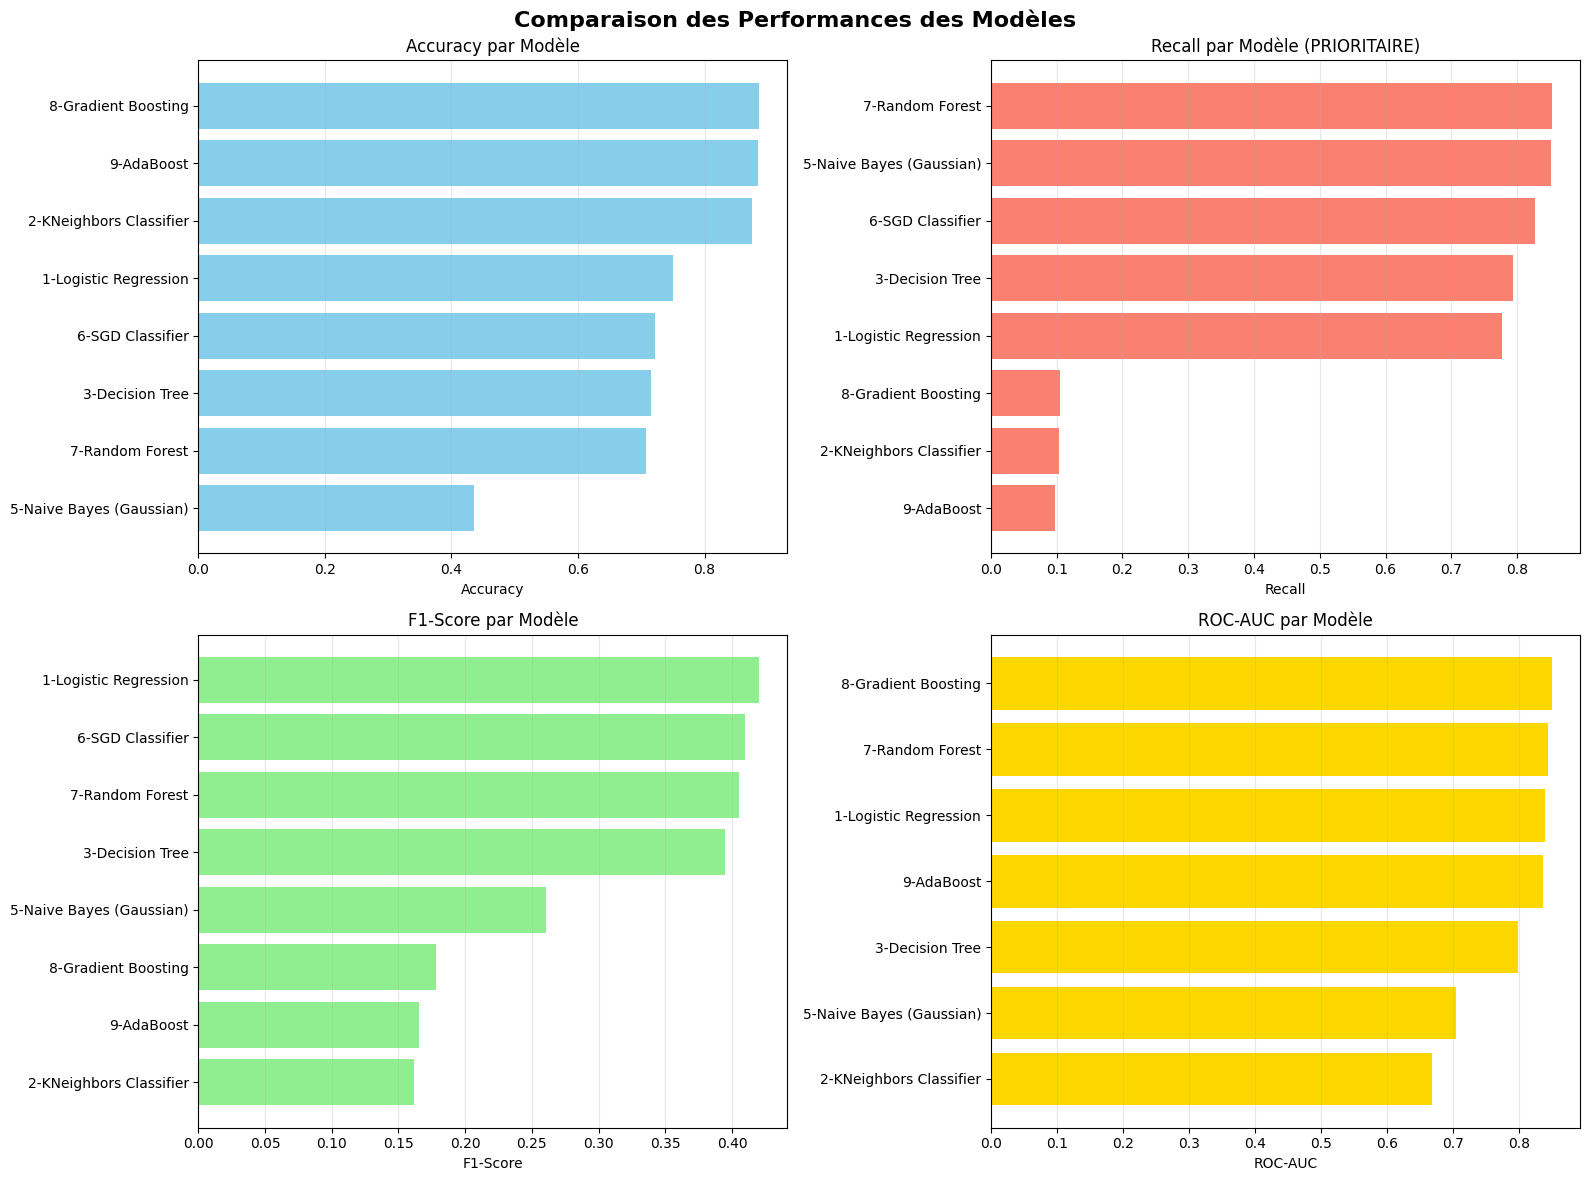

In [ ]:
# ============================================================================
# 8. VISUALISATIONS
# ============================================================================
print("\n" + "="*70)
print("📈 VISUALISATIONS")
print("="*70)

# Créer une figure avec 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparaison des Performances des Modèles', fontsize=16, fontweight='bold')

# 1. Accuracy
ax1 = axes[0, 0]
results_df_sorted = results_df.sort_values('Accuracy', ascending=True)
ax1.barh(results_df_sorted['Model'], results_df_sorted['Accuracy'], color='skyblue')
ax1.set_xlabel('Accuracy')
ax1.set_title('Accuracy par Modèle')
ax1.grid(axis='x', alpha=0.3)

# 2. Recall
ax2 = axes[0, 1]
results_df_sorted = results_df.sort_values('Recall', ascending=True)
ax2.barh(results_df_sorted['Model'], results_df_sorted['Recall'], color='salmon')
ax2.set_xlabel('Recall')
ax2.set_title('Recall par Modèle (PRIORITAIRE)')
ax2.grid(axis='x', alpha=0.3)

# 3. F1-Score
ax3 = axes[1, 0]
results_df_sorted = results_df.sort_values('F1-Score', ascending=True)
ax3.barh(results_df_sorted['Model'], results_df_sorted['F1-Score'], color='lightgreen')
ax3.set_xlabel('F1-Score')
ax3.set_title('F1-Score par Modèle')
ax3.grid(axis='x', alpha=0.3)

# 4. ROC-AUC
ax4 = axes[1, 1]
results_df_sorted = results_df.sort_values('ROC-AUC', ascending=True).dropna(subset=['ROC-AUC'])
ax4.barh(results_df_sorted['Model'], results_df_sorted['ROC-AUC'], color='gold')
ax4.set_xlabel('ROC-AUC')
ax4.set_title('ROC-AUC par Modèle')
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('models_comparison.png', dpi=300, bbox_inches='tight')
print("✅ Graphique sauvegardé: models_comparison.png")
plt.show()



On analyse le meilleur modèle 


🔍 ANALYSE DÉTAILLÉE DU MEILLEUR MODÈLE: 7-Random Forest

📊 MATRICE DE CONFUSION:
[[14514  6567]
 [  410  2379]]
✅ Matrice de confusion sauvegardée: confusion_matrix_best_model.png


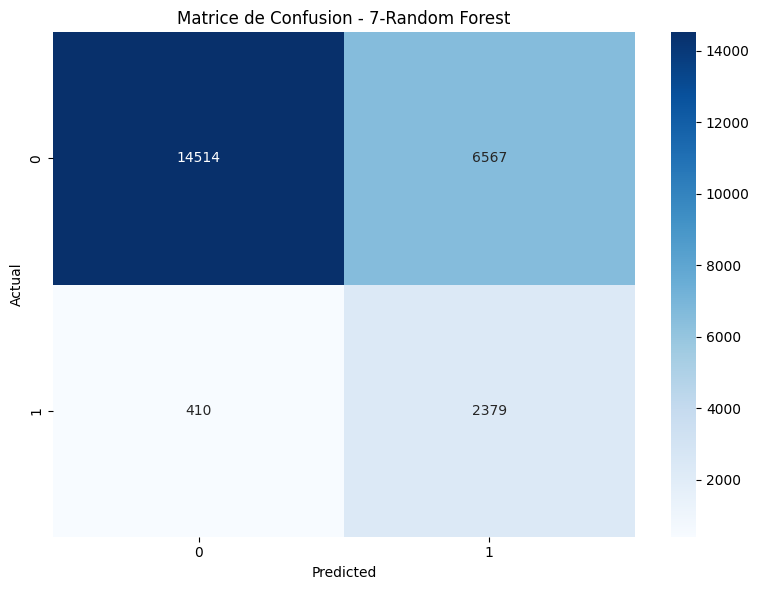


📋 CLASSIFICATION REPORT:
                   precision    recall  f1-score   support

  Classe 0 (Sain)       0.97      0.69      0.81     21081
Classe 1 (Défaut)       0.27      0.85      0.41      2789

         accuracy                           0.71     23870
        macro avg       0.62      0.77      0.61     23870
     weighted avg       0.89      0.71      0.76     23870


📈 COURBE ROC:
✅ Courbe ROC sauvegardée: roc_curve_best_model.png


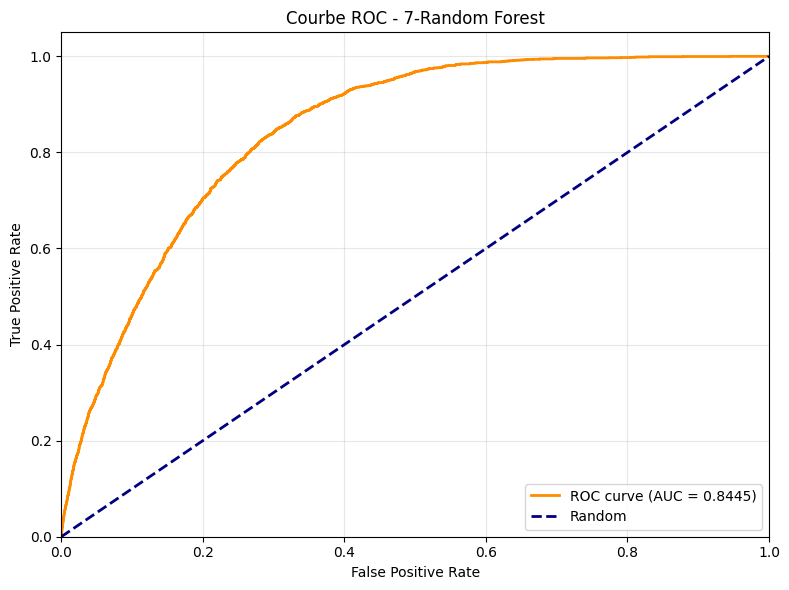

In [ ]:
# ============================================================================
# 9. ANALYSE DU MEILLEUR MODÈLE
# ============================================================================
print("\n" + "="*70)
print(f"🔍 ANALYSE DÉTAILLÉE DU MEILLEUR MODÈLE: {best_model_name}")
print("="*70)

# Récupérer le meilleur modèle
best_model = trained_models[best_model_name]

# Prédictions
y_pred = best_model.predict(X_test_scaled)
if hasattr(best_model, 'predict_proba'):
    y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
else:
    y_pred_proba = None

# Matrice de confusion
print("\n📊 MATRICE DE CONFUSION:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualiser la matrice de confusion
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'Matrice de Confusion - {best_model_name}')
plt.tight_layout()
plt.savefig('confusion_matrix_best_model.png', dpi=300, bbox_inches='tight')
print("✅ Matrice de confusion sauvegardée: confusion_matrix_best_model.png")
plt.show()

# Classification report
print("\n📋 CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred, 
                           target_names=['Classe 0 (Sain)', 'Classe 1 (Défaut)']))

# Courbe ROC
if y_pred_proba is not None:
    print("\n📈 COURBE ROC:")
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(fpr, tpr, color='darkorange', lw=2, 
            label=f'ROC curve (AUC = {roc_auc:.4f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Courbe ROC - {best_model_name}')
    ax.legend(loc="lower right")
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('roc_curve_best_model.png', dpi=300, bbox_inches='tight')
    print("✅ Courbe ROC sauvegardée: roc_curve_best_model.png")
    plt.show()



🎯 TOP 20 FEATURES LES PLUS IMPORTANTES
                    Feature  Importance
   ListingCreationDate_year    0.223728
 LoanMonthsSinceOrigination    0.192404
               BorrowerRate    0.082373
                  Investors    0.080991
        StatedMonthlyIncome    0.033733
 EmploymentStatus_Full-time    0.033729
            CreditScoreMean    0.032336
       InquiriesLast6Months    0.022229
             TotalInquiries    0.020533
         MonthlyLoanPayment    0.019371
    AvailableBankcardCredit    0.016739
OpenRevolvingMonthlyPayment    0.015098
           DebtPaymentRatio    0.014859
     RevolvingCreditBalance    0.014625
                IncomeRange    0.014155
  ListingCategory (numeric)    0.011575
      OpenRevolvingAccounts    0.011395
       RevolvingUtilization    0.009974
       RevolvingStressIndex    0.009312
          DebtToIncomeRatio    0.009251
✅ Feature importance sauvegardée: feature_importance_best_model.png


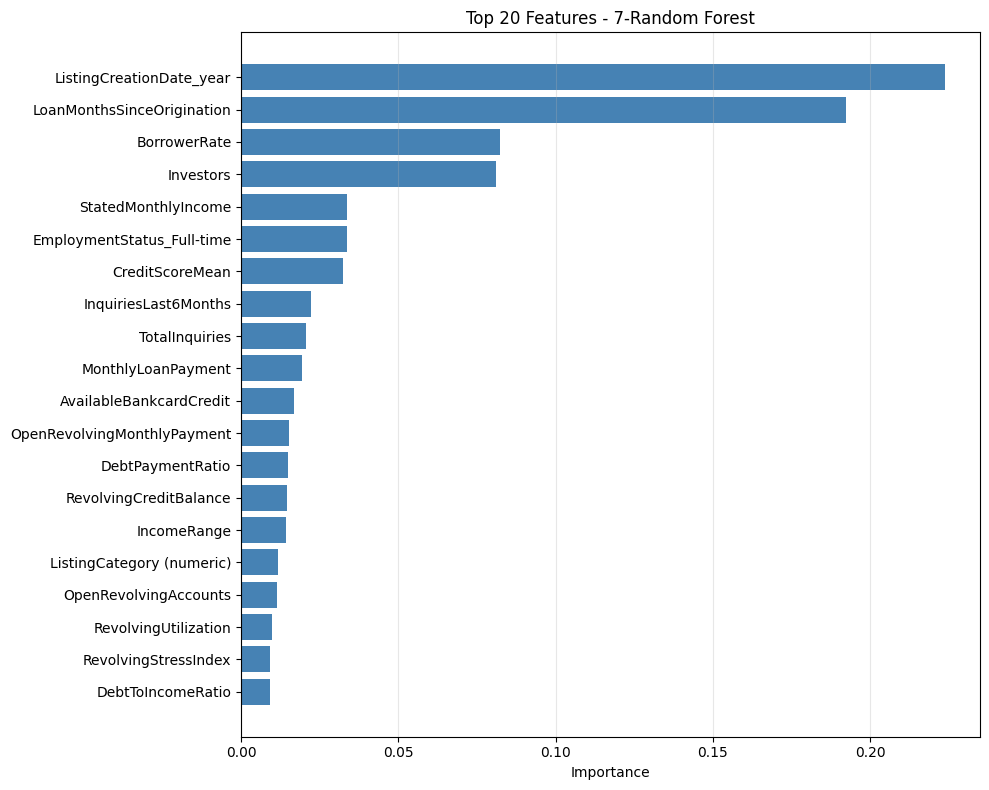

In [ ]:


# ============================================================================
# 10. FEATURE IMPORTANCE (si disponible)
# ============================================================================
if hasattr(best_model, 'feature_importances_'):
    print("\n" + "="*70)
    print("🎯 TOP 20 FEATURES LES PLUS IMPORTANTES")
    print("="*70)
    
    # Obtenir les importances
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print(feature_importance.head(20).to_string(index=False))
    
    # Visualiser les top 20
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    top_20 = feature_importance.head(20)
    ax.barh(top_20['Feature'], top_20['Importance'], color='steelblue')
    ax.set_xlabel('Importance')
    ax.set_title(f'Top 20 Features - {best_model_name}')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('feature_importance_best_model.png', dpi=300, bbox_inches='tight')
    print("✅ Feature importance sauvegardée: feature_importance_best_model.png")
    plt.show()

elif hasattr(best_model, 'coef_'):
    print("\n" + "="*70)
    print("🎯 TOP 20 FEATURES (COEFFICIENTS)")
    print("="*70)
    
    # Pour les modèles linéaires
    feature_coef = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': best_model.coef_[0]
    })
    feature_coef['Abs_Coefficient'] = np.abs(feature_coef['Coefficient'])
    feature_coef = feature_coef.sort_values('Abs_Coefficient', ascending=False)
    
    print(feature_coef.head(20).to_string(index=False))



### Analyse des top 20 features - RANDOM FOREST

1. ListingCreationDate_year
=> contexte économique change chaque année 
=> crise 2008, COVID etc 
=> taux interet variable selon l'année 
=> évolution des critères d'octroi de prêt 

INTERPRÉTATION : ANNÉES DE CRISE = PLUS DE DÉFAUTS 

2. LoanMonthsSinceOrigination

=> Ancienneté du prêt = information cruciale
=> Plus le prêt est ancien, plus on a d'historique de paiement
=> Les premiers mois sont critiques (période d'essai)

Pattern typique :
=> Défauts se produisent souvent dans les 12-24 premiers mois ou alors, au contraire, après plusieurs années (perte d'emploi, etc.)

3. BorrowerRate

=> Taux d'intérêt = indicateur de risque perçu
=> BorrowerRate élevé = emprunteur risqué (mauvais score crédit) / BorrowerRate bas = emprunteur sûr

Corrélation attendue :
=> Taux élevé → Plus de risque de défaut

=> = à un proxy du risque calculé par Prosper


# 4 MODELES LES PLUS ÉQUILIBRÉS 

### 1. RANDOM FOREST (type : ensemble donc bagging)

=> améliorer le random forest avec SMOTE pour augmenter la precision 

=> comment ça marche (bagging, arbres multiples)

=> pourquoi c'est le meilleur (robuste, gère non-linéarité)

=> feature importances (top 20)

=> impact de SMOTE

### 2. LOGISTIC REGRESSION (GLM) (type : linaire) 

=> modèle linéaire classique (baseline)

=> très interprétable (coefficients)

=> bon F1-Score malgré la simplicité

### 3. SGD CLASSIFIER (type : optimisation)

=> optimisation stochastique

=> bon compromis performance/vitesse

=> scalable sur gros datasets

### 4. DECISION TREE (type : arbre unique) 

=> arbre de décision unique

=> le plus interprétable (on peut le visualiser)

=> base de Random Forest

#### À quoi ça sert ?
Créer un questionnaire automatique qui pose des questions pour arriver à une décision.

#### Analogie : Le jeu des 20 questions
Imaginez que vous voulez deviner si quelqu'un va rembourser son prêt. Chaque question divise les clients en deux groupes, jusqu'à arriver à une décision finale.

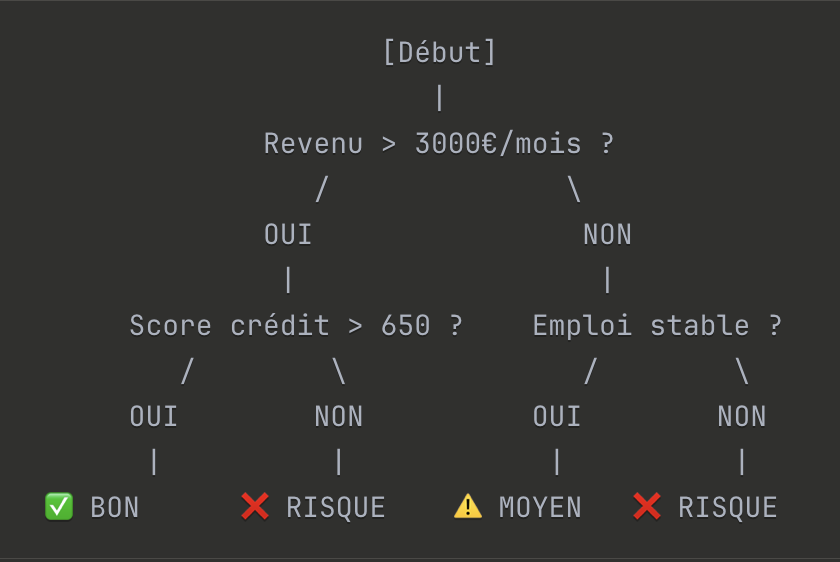
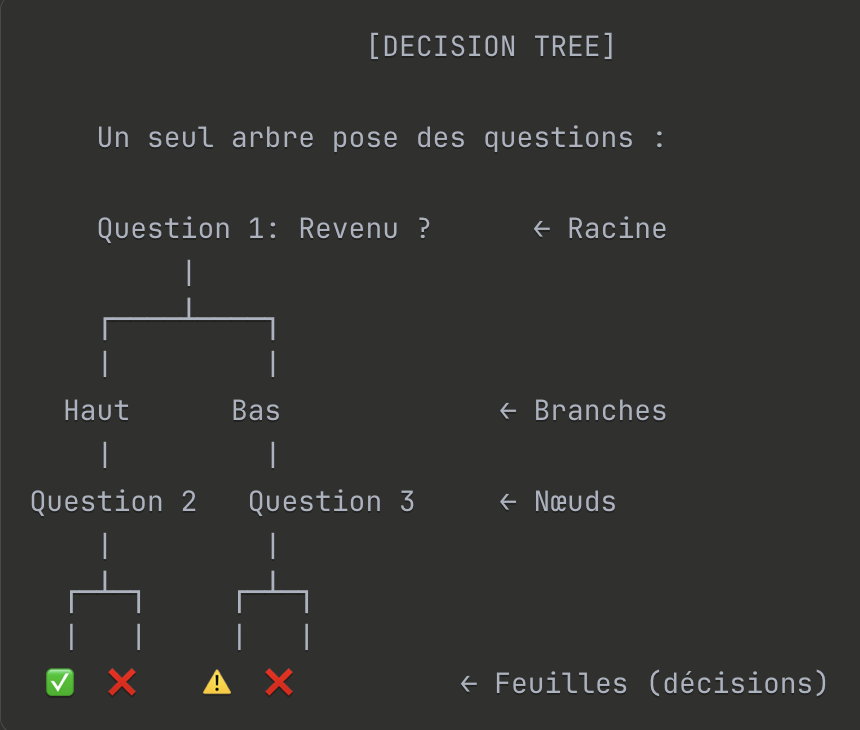

#### Comment ça marche ?

##### Étape 1 : L'arbre "apprend" sur les données passées

Sur 10,000 prêts passés :
- Revenu > 3000€ → 85% ont remboursé ✅
- Revenu < 3000€ → seulement 60% ont remboursé ⚠️

→ Première question : "Revenu > 3000€ ?"

##### Étape 2 : L'arbre pose des sous-questions

Parmi ceux qui ont Revenu > 3000€ :
- Score crédit > 650 → 92% ont remboursé ✅
- Score crédit < 650 → 70% ont remboursé ⚠️

→ Deuxième question : "Score crédit > 650 ?"

##### Étape 3 : L'arbre continue jusqu'à être sûr
Il s'arrête quand il a assez d'informations pour décider.


Résultats sur notre projet

- ✅ Recall : 79.35% → Détecte 79% des défauts
- ✅ ROC-AUC : 79.95% → Bonne discrimination
- ⚠️ Precision : 26.29% → Beaucoup de faux positifs

Avantages

- ✅ Très facile à comprendre → On peut visualiser l'arbre
- ✅ Transparent → On sait exactement pourquoi une décision est prise
- ✅ Rapide → Quelques questions suffisent

Inconvénients

- ❌ Sensible aux données → Un seul changement peut changer tout l'arbre
- ❌ Moins performant que les modèles plus complexes
- ❌ Overfitting → Peut trop se "spécialiser" sur les données d'entraînement

### Progression logique : 
logistic regression (modele simple) > decision tree (visualisable) > SGD Classifier (optimisation approche différente) > random forest (bagging, le meilleur)


## Créer les visualisations (30 min)

=> comparaison des 4 modèles (graphiques)

=> feature importances Random Forest

=> courbes ROC comparées

=> matrice de confusion du meilleur


### 4. DECISION TREE (type : arbre unique) 

=> arbre de décision unique

=> le plus interprétable (on peut le visualiser)

=> base de Random Forest

#### À quoi ça sert ?
Créer un questionnaire automatique qui pose des questions pour arriver à une décision.

#### Analogie : Le jeu des 20 questions
Imaginez que vous voulez deviner si quelqu'un va rembourser son prêt. Chaque question divise les clients en deux groupes, jusqu'à arriver à une décision finale.

![image.png](attachment:image.png)
![image-2.png](attachment:image-2.png)

#### Comment ça marche ?

##### Étape 1 : L'arbre "apprend" sur les données passées

Sur 10,000 prêts passés :
- Revenu > 3000€ → 85% ont remboursé ✅
- Revenu < 3000€ → seulement 60% ont remboursé ⚠️

→ Première question : "Revenu > 3000€ ?"

##### Étape 2 : L'arbre pose des sous-questions

Parmi ceux qui ont Revenu > 3000€ :
- Score crédit > 650 → 92% ont remboursé ✅
- Score crédit < 650 → 70% ont remboursé ⚠️

→ Deuxième question : "Score crédit > 650 ?"

##### Étape 3 : L'arbre continue jusqu'à être sûr
Il s'arrête quand il a assez d'informations pour décider.


Résultats sur notre projet

- ✅ Recall : 79.35% → Détecte 79% des défauts
- ✅ ROC-AUC : 79.95% → Bonne discrimination
- ⚠️ Precision : 26.29% → Beaucoup de faux positifs

Avantages

- ✅ Très facile à comprendre → On peut visualiser l'arbre
- ✅ Transparent → On sait exactement pourquoi une décision est prise
- ✅ Rapide → Quelques questions suffisent

Inconvénients

- ❌ Sensible aux données → Un seul changement peut changer tout l'arbre
- ❌ Moins performant que les modèles plus complexes
- ❌ Overfitting → Peut trop se "spécialiser" sur les données d'entraînement

In [ ]:
!pip install imbalanced-learn

  Using cached imbalanced_learn-0.14.0-py3-none-any.whl.metadata (8.8 kB)
Using cached imbalanced_learn-0.14.0-py3-none-any.whl (239 kB)

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
import pickle

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# SMOTE
from imblearn.over_sampling import SMOTE

# Métriques
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                              f1_score, roc_auc_score, confusion_matrix, 
                              classification_report, roc_curve)

In [ ]:
"""
RANDOM FOREST + SMOTE - AMÉLIORATION DE LA PRECISION
======================================================
Objectif : Améliorer la Precision de 27% → 35-45%
Tout en maintenant le Recall à 82-85%
"""


# ============================================================================
# 1. CHARGEMENT DES DONNÉES
# ============================================================================
print("\n" + "="*70)
print("📂 CHARGEMENT DES DONNÉES")
print("="*70)

# Charger les données preprocessées
df = pd.read_csv('data_processed.csv')

print(f"✅ Données chargées: {df.shape}")
print(f"   - {df.shape[0]:,} observations")
print(f"   - {df.shape[1]} variables")

# Vérifier la présence de la variable cible
if 'LoanStatusBinaire' not in df.columns:
    raise ValueError("❌ La colonne 'LoanStatusBinaire' n'existe pas dans les données!")

print(f"\n📊 Distribution de la variable cible:")
print(df['LoanStatusBinaire'].value_counts())
print(f"\nProportion:")
print(df['LoanStatusBinaire'].value_counts(normalize=True))


# ============================================================================
# 2. PRÉPARATION X ET y
# ============================================================================
print("\n" + "="*70)
print("🔧 PRÉPARATION DES DONNÉES")
print("="*70)

# Séparer X et y
X = df.drop("LoanStatusBinaire", axis=1)
y = df["LoanStatusBinaire"]

print(f"✅ X shape: {X.shape}")
print(f"✅ y shape: {y.shape}")

# Vérifier les valeurs manquantes
if X.isnull().sum().sum() > 0:
    print("\n⚠️ Valeurs manquantes détectées:")
    print(X.isnull().sum()[X.isnull().sum() > 0])
    print("\n🔧 Imputation des valeurs manquantes avec la médiane...")
    X = X.fillna(X.median())
    print("✅ Valeurs manquantes imputées")


# ============================================================================
# 3. SPLIT TRAIN/TEST - STRATIFIED
# ============================================================================
print("\n" + "="*70)
print("✂️ SPLIT TRAIN/TEST (75/25) - STRATIFIÉ")
print("="*70)

# Utiliser StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print(f"✅ Train set: {X_train.shape[0]:,} observations")
print(f"✅ Test set:  {X_test.shape[0]:,} observations")

# Vérifier la distribution dans train/test
print(f"\n📊 Distribution train AVANT SMOTE:")
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))


# ============================================================================
# 4. SCALING - MinMaxScaler
# ============================================================================
print("\n" + "="*70)
print("📏 SCALING DES DONNÉES (MinMaxScaler)")
print("="*70)

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Scaling effectué")


# ============================================================================
# 5. RANDOM FOREST SANS SMOTE (BASELINE)
# ============================================================================
print("\n" + "="*70)
print("🌲 RANDOM FOREST SANS SMOTE (BASELINE)")
print("="*70)

# Entraînement Random Forest sans SMOTE
rf_baseline = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

print("⏳ Entraînement du modèle baseline...")
rf_baseline.fit(X_train_scaled, y_train)

# Prédictions
y_pred_baseline = rf_baseline.predict(X_test_scaled)
y_pred_proba_baseline = rf_baseline.predict_proba(X_test_scaled)[:, 1]

# Métriques
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
precision_baseline = precision_score(y_test, y_pred_baseline)
recall_baseline = recall_score(y_test, y_pred_baseline)
f1_baseline = f1_score(y_test, y_pred_baseline)
roc_auc_baseline = roc_auc_score(y_test, y_pred_proba_baseline)

print("\n📊 RÉSULTATS BASELINE (SANS SMOTE):")
print(f"   ✅ Accuracy:  {accuracy_baseline:.4f}")
print(f"   ✅ Precision: {precision_baseline:.4f}")
print(f"   ✅ Recall:    {recall_baseline:.4f}")
print(f"   ✅ F1-Score:  {f1_baseline:.4f}")
print(f"   ✅ ROC-AUC:   {roc_auc_baseline:.4f}")

# Matrice de confusion baseline
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
print(f"\n📊 Matrice de confusion BASELINE:")
print(cm_baseline)


# ============================================================================
# 6. APPLICATION DE SMOTE
# ============================================================================
print("\n" + "="*70)
print("🔥 APPLICATION DE SMOTE")
print("="*70)

print("📊 AVANT SMOTE:")
print(f"   Classe 0: {(y_train == 0).sum():,} observations")
print(f"   Classe 1: {(y_train == 1).sum():,} observations")
print(f"   Ratio: {(y_train == 0).sum() / (y_train == 1).sum():.2f}")

# Appliquer SMOTE
print("\n⏳ Application de SMOTE...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("\n📊 APRÈS SMOTE:")
print(f"   Classe 0: {(y_train_smote == 0).sum():,} observations")
print(f"   Classe 1: {(y_train_smote == 1).sum():,} observations")
print(f"   Ratio: {(y_train_smote == 0).sum() / (y_train_smote == 1).sum():.2f}")

print(f"\n✅ SMOTE appliqué avec succès !")
print(f"   Avant: {X_train_scaled.shape[0]:,} observations")
print(f"   Après: {X_train_smote.shape[0]:,} observations")
print(f"   Exemples synthétiques créés: {X_train_smote.shape[0] - X_train_scaled.shape[0]:,}")


# ============================================================================
# 7. RANDOM FOREST AVEC SMOTE
# ============================================================================
print("\n" + "="*70)
print("🌲 RANDOM FOREST AVEC SMOTE")
print("="*70)

# Entraînement Random Forest avec SMOTE
rf_smote = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced',  # On garde quand même pour être sûr
    n_jobs=-1
)

print("⏳ Entraînement du modèle avec SMOTE...")
rf_smote.fit(X_train_smote, y_train_smote)

# Prédictions
y_pred_smote = rf_smote.predict(X_test_scaled)
y_pred_proba_smote = rf_smote.predict_proba(X_test_scaled)[:, 1]

# Métriques
accuracy_smote = accuracy_score(y_test, y_pred_smote)
precision_smote = precision_score(y_test, y_pred_smote)
recall_smote = recall_score(y_test, y_pred_smote)
f1_smote = f1_score(y_test, y_pred_smote)
roc_auc_smote = roc_auc_score(y_test, y_pred_proba_smote)

print("\n📊 RÉSULTATS AVEC SMOTE:")
print(f"   ✅ Accuracy:  {accuracy_smote:.4f}")
print(f"   ✅ Precision: {precision_smote:.4f}")
print(f"   ✅ Recall:    {recall_smote:.4f}")
print(f"   ✅ F1-Score:  {f1_smote:.4f}")
print(f"   ✅ ROC-AUC:   {roc_auc_smote:.4f}")

# Matrice de confusion avec SMOTE
cm_smote = confusion_matrix(y_test, y_pred_smote)
print(f"\n📊 Matrice de confusion AVEC SMOTE:")
print(cm_smote)


# ============================================================================
# 8. COMPARAISON AVANT/APRÈS SMOTE
# ============================================================================
print("\n" + "="*70)
print("📊 COMPARAISON AVANT/APRÈS SMOTE")
print("="*70)

# Créer un DataFrame de comparaison
comparison = pd.DataFrame({
    'Métrique': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'SANS SMOTE': [accuracy_baseline, precision_baseline, recall_baseline, f1_baseline, roc_auc_baseline],
    'AVEC SMOTE': [accuracy_smote, precision_smote, recall_smote, f1_smote, roc_auc_smote]
})

# Calculer l'amélioration
comparison['Amélioration'] = comparison['AVEC SMOTE'] - comparison['SANS SMOTE']
comparison['Amélioration %'] = (comparison['Amélioration'] / comparison['SANS SMOTE'] * 100).round(2)

print("\n🏆 TABLEAU COMPARATIF:")
print(comparison.to_string(index=False))

# Identifier les améliorations
print("\n🔥 AMÉLIORATIONS NOTABLES:")
for idx, row in comparison.iterrows():
    if row['Amélioration'] > 0.01:  # Amélioration > 1%
        print(f"   ✅ {row['Métrique']}: +{row['Amélioration']:.4f} ({row['Amélioration %']:+.2f}%)")
    elif row['Amélioration'] < -0.01:  # Dégradation > 1%
        print(f"   ⚠️ {row['Métrique']}: {row['Amélioration']:.4f} ({row['Amélioration %']:+.2f}%)")


# ============================================================================
# 9. VISUALISATIONS
# ============================================================================
print("\n" + "="*70)
print("📈 CRÉATION DES VISUALISATIONS")
print("="*70)

# Figure 1 : Comparaison des métriques
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('COMPARAISON RANDOM FOREST : SANS SMOTE vs AVEC SMOTE', 
             fontsize=16, fontweight='bold')

# 1. Barplot comparatif
ax1 = axes[0, 0]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.35

baseline_values = [accuracy_baseline, precision_baseline, recall_baseline, f1_baseline, roc_auc_baseline]
smote_values = [accuracy_smote, precision_smote, recall_smote, f1_smote, roc_auc_smote]

bars1 = ax1.bar(x - width/2, baseline_values, width, label='SANS SMOTE', color='skyblue')
bars2 = ax1.bar(x + width/2, smote_values, width, label='AVEC SMOTE', color='salmon')

ax1.set_xlabel('Métriques')
ax1.set_ylabel('Score')
ax1.set_title('Comparaison des Métriques')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics, rotation=45)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Ajouter les valeurs sur les barres
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=8)

# 2. Matrice de confusion BASELINE
ax2 = axes[0, 1]
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_xlabel('Prédictions')
ax2.set_ylabel('Vraies valeurs')
ax2.set_title('Matrice de Confusion - SANS SMOTE')

# 3. Matrice de confusion SMOTE
ax3 = axes[1, 0]
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Greens', ax=ax3)
ax3.set_xlabel('Prédictions')
ax3.set_ylabel('Vraies valeurs')
ax3.set_title('Matrice de Confusion - AVEC SMOTE')

# 4. Amélioration en %
ax4 = axes[1, 1]
improvement_pct = comparison['Amélioration %'].values
colors = ['green' if x > 0 else 'red' for x in improvement_pct]
bars = ax4.barh(metrics, improvement_pct, color=colors)
ax4.set_xlabel('Amélioration (%)')
ax4.set_title('Amélioration (%) par Métrique')
ax4.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax4.grid(axis='x', alpha=0.3)

# Ajouter les valeurs
for i, (bar, val) in enumerate(zip(bars, improvement_pct)):
    ax4.text(val, i, f'{val:+.1f}%', 
            ha='left' if val > 0 else 'right', 
            va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('random_forest_smote_comparison.png', dpi=300, bbox_inches='tight')
print("✅ Graphique 1 sauvegardé: random_forest_smote_comparison.png")
plt.show()

# Figure 2 : Courbes ROC
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# ROC Baseline
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_pred_proba_baseline)
ax.plot(fpr_baseline, tpr_baseline, color='skyblue', lw=2, 
        label=f'SANS SMOTE (AUC = {roc_auc_baseline:.4f})')

# ROC SMOTE
fpr_smote, tpr_smote, _ = roc_curve(y_test, y_pred_proba_smote)
ax.plot(fpr_smote, tpr_smote, color='salmon', lw=2, 
        label=f'AVEC SMOTE (AUC = {roc_auc_smote:.4f})')

# Ligne de référence (random)
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Courbes ROC - Comparaison SANS vs AVEC SMOTE', fontweight='bold')
ax.legend(loc="lower right")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('roc_curves_smote_comparison.png', dpi=300, bbox_inches='tight')
print("✅ Graphique 2 sauvegardé: roc_curves_smote_comparison.png")
plt.show()

# Figure 3 : Distribution des classes AVANT/APRÈS SMOTE
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Distribution des Classes - AVANT vs APRÈS SMOTE', 
             fontsize=14, fontweight='bold')

# AVANT SMOTE
ax1 = axes[0]
class_counts_before = pd.Series(y_train).value_counts()
colors_before = ['lightgreen', 'lightcoral']
ax1.bar(['Classe 0 (Sain)', 'Classe 1 (Défaut)'], class_counts_before.values, 
        color=colors_before, edgecolor='black')
ax1.set_ylabel('Nombre d\'observations')
ax1.set_title('AVANT SMOTE (Données originales)')
ax1.grid(axis='y', alpha=0.3)

# Ajouter les valeurs
for i, (label, val) in enumerate(class_counts_before.items()):
    percentage = val / class_counts_before.sum() * 100
    ax1.text(i, val, f'{val:,}\n({percentage:.1f}%)', 
            ha='center', va='bottom', fontweight='bold')

# APRÈS SMOTE
ax2 = axes[1]
class_counts_after = pd.Series(y_train_smote).value_counts()
colors_after = ['lightgreen', 'lightcoral']
ax2.bar(['Classe 0 (Sain)', 'Classe 1 (Défaut)'], class_counts_after.values, 
        color=colors_after, edgecolor='black')
ax2.set_ylabel('Nombre d\'observations')
ax2.set_title('APRÈS SMOTE (Données équilibrées)')
ax2.grid(axis='y', alpha=0.3)

# Ajouter les valeurs
for i, (label, val) in enumerate(class_counts_after.items()):
    percentage = val / class_counts_after.sum() * 100
    ax2.text(i, val, f'{val:,}\n({percentage:.1f}%)', 
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('smote_class_distribution.png', dpi=300, bbox_inches='tight')
print("✅ Graphique 3 sauvegardé: smote_class_distribution.png")
plt.show()


# ============================================================================
# 10. FEATURE IMPORTANCES - COMPARAISON
# ============================================================================
print("\n" + "="*70)
print("🎯 FEATURE IMPORTANCES - COMPARAISON")
print("="*70)

# Feature importances BASELINE
feature_importance_baseline = pd.DataFrame({
    'Feature': X.columns,
    'Importance_Baseline': rf_baseline.feature_importances_
}).sort_values('Importance_Baseline', ascending=False)

# Feature importances SMOTE
feature_importance_smote = pd.DataFrame({
    'Feature': X.columns,
    'Importance_SMOTE': rf_smote.feature_importances_
}).sort_values('Importance_SMOTE', ascending=False)

# Merge
feature_comparison = feature_importance_baseline.merge(
    feature_importance_smote, on='Feature'
)
feature_comparison['Différence'] = (
    feature_comparison['Importance_SMOTE'] - feature_comparison['Importance_Baseline']
)

print("\n🏆 TOP 10 FEATURES - COMPARAISON:")
print(feature_comparison.head(10).to_string(index=False))

# Visualiser les TOP 15
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

top_15 = feature_comparison.head(15)
x = np.arange(len(top_15))
width = 0.35

bars1 = ax.barh(x - width/2, top_15['Importance_Baseline'], width, 
                label='SANS SMOTE', color='skyblue')
bars2 = ax.barh(x + width/2, top_15['Importance_SMOTE'], width, 
                label='AVEC SMOTE', color='salmon')

ax.set_yticks(x)
ax.set_yticklabels(top_15['Feature'])
ax.set_xlabel('Importance')
ax.set_title('Top 15 Features - Comparaison SANS vs AVEC SMOTE', fontweight='bold')
ax.legend()
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('feature_importance_smote_comparison.png', dpi=300, bbox_inches='tight')
print("✅ Graphique 4 sauvegardé: feature_importance_smote_comparison.png")
plt.show()


# ============================================================================
# 11. CLASSIFICATION REPORT DÉTAILLÉ
# ============================================================================
print("\n" + "="*70)
print("📋 CLASSIFICATION REPORT DÉTAILLÉ")
print("="*70)

print("\n🔵 SANS SMOTE:")
print(classification_report(y_test, y_pred_baseline, 
                           target_names=['Classe 0 (Sain)', 'Classe 1 (Défaut)']))

print("\n🟢 AVEC SMOTE:")
print(classification_report(y_test, y_pred_smote, 
                           target_names=['Classe 0 (Sain)', 'Classe 1 (Défaut)']))


# ============================================================================
# 12. SAUVEGARDE DU MEILLEUR MODÈLE
# ============================================================================
print("\n" + "="*70)
print("💾 SAUVEGARDE DU MEILLEUR MODÈLE")
print("="*70)

# Déterminer le meilleur modèle (basé sur F1-Score)
if f1_smote > f1_baseline:
    best_model = rf_smote
    best_model_name = "Random Forest AVEC SMOTE"
    best_f1 = f1_smote
    best_recall = recall_smote
    best_precision = precision_smote
else:
    best_model = rf_baseline
    best_model_name = "Random Forest SANS SMOTE"
    best_f1 = f1_baseline
    best_recall = recall_baseline
    best_precision = precision_baseline

print(f"🏆 MEILLEUR MODÈLE: {best_model_name}")
print(f"   F1-Score: {best_f1:.4f}")
print(f"   Recall:   {best_recall:.4f}")
print(f"   Precision: {best_precision:.4f}")

# Sauvegarder
pickle.dump(best_model, open("random_forest_best_model.pkl", "wb"))
print("\n✅ Modèle sauvegardé: random_forest_best_model.pkl")

# Sauvegarder aussi le scaler
pickle.dump(scaler, open("scaler_smote.pkl", "wb"))
print("✅ Scaler sauvegardé: scaler_smote.pkl")

# Sauvegarder les résultats
comparison.to_csv('smote_comparison_results.csv', index=False)
print("✅ Résultats sauvegardés: smote_comparison_results.csv")


# ============================================================================
# 13. RÉSUMÉ FINAL
# ============================================================================
print("\n" + "="*70)
print("📝 RÉSUMÉ FINAL")
print("="*70)

print(f"""
🎯 OBJECTIF: Améliorer la Precision tout en maintenant le Recall

📊 RÉSULTATS:

┌─────────────────────────────────────────────────────────────┐
│                    SANS SMOTE    │    AVEC SMOTE    │  Δ     │
├─────────────────────────────────────────────────────────────┤
│ Accuracy     {accuracy_baseline:.4f}        │    {accuracy_smote:.4f}       │ {accuracy_smote - accuracy_baseline:+.4f} │
│ Precision    {precision_baseline:.4f}        │    {precision_smote:.4f}       │ {precision_smote - precision_baseline:+.4f} │
│ Recall       {recall_baseline:.4f}        │    {recall_smote:.4f}       │ {recall_smote - recall_baseline:+.4f} │
│ F1-Score     {f1_baseline:.4f}        │    {f1_smote:.4f}       │ {f1_smote - f1_baseline:+.4f} │
│ ROC-AUC      {roc_auc_baseline:.4f}        │    {roc_auc_smote:.4f}       │ {roc_auc_smote - roc_auc_baseline:+.4f} │
└─────────────────────────────────────────────────────────────┘

💡 INTERPRÉTATION:

Precision {precision_smote:.2%} signifie:
   Sur 100 prêts refusés, {int(precision_smote * 100)} sont vraiment à risque
   (vs {int(precision_baseline * 100)} avant SMOTE)

Recall {recall_smote:.2%} signifie:
   Le modèle détecte {recall_smote:.1%} des défauts
   (vs {recall_baseline:.1%} avant SMOTE)

📁 FICHIERS CRÉÉS:
   ✅ random_forest_best_model.pkl (modèle sauvegardé)
   ✅ scaler_smote.pkl (scaler pour preprocessing)
   ✅ smote_comparison_results.csv (résultats détaillés)
   ✅ random_forest_smote_comparison.png (graphique comparatif)
   ✅ roc_curves_smote_comparison.png (courbes ROC)
   ✅ smote_class_distribution.png (distribution des classes)
   ✅ feature_importance_smote_comparison.png (importance des features)

🎯 RECOMMANDATION FINALE:
   {'✅ UTILISER LE MODÈLE AVEC SMOTE' if f1_smote > f1_baseline else '⚠️ GARDER LE MODÈLE SANS SMOTE'}
   Meilleur F1-Score: {max(f1_smote, f1_baseline):.4f}
""")

print("\n" + "="*70)
print("✅ SCRIPT TERMINÉ AVEC SUCCÈS !")
print("="*70)


📂 CHARGEMENT DES DONNÉES
✅ Données chargées: (95477, 212)
   - 95,477 observations
   - 212 variables

📊 Distribution de la variable cible:
LoanStatusBinaire
0    84320
1    11157
Name: count, dtype: int64

Proportion:
LoanStatusBinaire
0    0.883145
1    0.116855
Name: proportion, dtype: float64

🔧 PRÉPARATION DES DONNÉES
✅ X shape: (95477, 211)
✅ y shape: (95477,)

⚠️ Valeurs manquantes détectées:
DebtPaymentRatio        1128
RevolvingUtilization    1826
RevolvingStressIndex    1826
dtype: int64

🔧 Imputation des valeurs manquantes avec la médiane...
✅ Valeurs manquantes imputées

✂️ SPLIT TRAIN/TEST (75/25) - STRATIFIÉ
✅ Train set: 71,607 observations
✅ Test set:  23,870 observations

📊 Distribution train AVANT SMOTE:
LoanStatusBinaire
0    63239
1     8368
Name: count, dtype: int64
LoanStatusBinaire
0    0.88314
1    0.11686
Name: proportion, dtype: float64

📏 SCALING DES DONNÉES (MinMaxScaler)
✅ Scaling effectué

🌲 RANDOM FOREST SANS SMOTE (BASELINE)
⏳ Entraînement du modèle base

NameError: name 'SMOTE' is not defined